# Finding SSMI CDR Antarctic Regional all polynya areas

* **Description**: Make "typical" polynya data files for annual, winter, and spring polynyas
    * CDR sea ice data per Laura's 4/19/22 email
* **Input data**: Processed polynya masks from L.Landrum
* **Output data**: Netcdf file with typical polynya masks and polynyas
* **Creator**: Alice DuVivier
* **Date**: October 2024

In [35]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
from datetime import datetime
import glob
import dask
from matplotlib.gridspec import GridSpec
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import nc_time_axis

import utils

## Get grid data

In [2]:
# load ocean grid
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [3]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


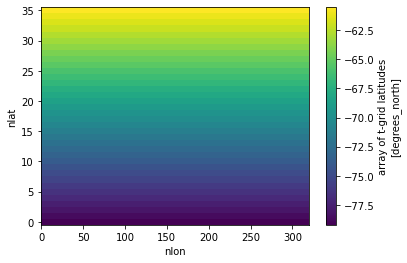

In [4]:
ds_grid.TLAT.plot()

## Load polynya data

In [5]:
# set data info

#dir_in = '/glade/work/landrum/projects/Antarctic_polynyas/SSMI_CDR/ice/polynyas/monthly/'
dir_in = '/glade/campaign/cgd/ppc/landrum/SSMI/polynyas/monthly/'

fin = 'SSMI.CDR.85%thresh.polynya2_sh.197901-202012.nc'

In [6]:
%%time
#reading in files
ds = []

print("loading CDR polynya data")   
my_files=sorted(glob.glob(dir_in+fin))
ds=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal',decode_times=True)

loading CDR polynya data
CPU times: user 7.29 ms, sys: 8.58 ms, total: 15.9 ms
Wall time: 301 ms


In [7]:
ds

<xarray.Dataset>
Dimensions:          (time: 504, lat: 76, lon: 320, polyID: 60)
Coordinates:
  * time             (time) float32 1.381e+05 1.381e+05 ... 1.534e+05 1.534e+05
  * polyID           (polyID) int32 1 2 3 4 5 6 7 8 ... 53 54 55 56 57 58 59 60
Dimensions without coordinates: lat, lon
Data variables:
    tlat1d           (lat) float32 dask.array<chunksize=(76,), meta=np.ndarray>
    tlon1d           (lon) float32 dask.array<chunksize=(320,), meta=np.ndarray>
    polynyas         (time, lat, lon) float64 dask.array<chunksize=(504, 76, 320), meta=np.ndarray>
    polynya_ID       (time, lat, lon) float64 dask.array<chunksize=(504, 76, 320), meta=np.ndarray>
    polynya_type     (time, polyID) float64 dask.array<chunksize=(504, 60), meta=np.ndarray>
    polynya_area     (time, polyID) float32 dask.array<chunksize=(504, 60), meta=np.ndarray>
    polynya_avg_lat  (time, polyID) float32 dask.array<chunksize=(504, 60), meta=np.ndarray>
    polynya_avg_lon  (time, polyID) float32 dask.array<chunksize=(504, 60), meta=np.ndarray>
Attributes:
    title:          SSMI monthly CDR SIC fields used to calculate polynya loc...
    program:        /glade/u/home/landrum/CESM_CCSM4/AntIce/SeaBird_Predators...
    creation_date:  Tue Apr 19 15:07:44 MDT 2022

In [8]:
# rename dimensions to be nlat and nlon
ds = ds.rename({'lat':'nlat'})
ds = ds.rename({'lon':'nlon'})

In [9]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds = ds.where(((ds['tlat1d'] <= lat_max) & (ds['tlat1d'] >= lat_min)), drop=True)

In [10]:
ds

<xarray.Dataset>
Dimensions:          (nlat: 36, nlon: 320, time: 504, polyID: 60)
Coordinates:
  * time             (time) float32 1.381e+05 1.381e+05 ... 1.534e+05 1.534e+05
  * polyID           (polyID) int32 1 2 3 4 5 6 7 8 ... 53 54 55 56 57 58 59 60
Dimensions without coordinates: nlat, nlon
Data variables:
    tlat1d           (nlat) float32 dask.array<chunksize=(36,), meta=np.ndarray>
    tlon1d           (nlon, nlat) float32 dask.array<chunksize=(320, 36), meta=np.ndarray>
    polynyas         (time, nlat, nlon) float64 dask.array<chunksize=(504, 36, 320), meta=np.ndarray>
    polynya_ID       (time, nlat, nlon) float64 dask.array<chunksize=(504, 36, 320), meta=np.ndarray>
    polynya_type     (time, polyID, nlat) float64 dask.array<chunksize=(504, 60, 36), meta=np.ndarray>
    polynya_area     (time, polyID, nlat) float32 dask.array<chunksize=(504, 60, 36), meta=np.ndarray>
    polynya_avg_lat  (time, polyID, nlat) float32 dask.array<chunksize=(504, 60, 36), meta=np.ndarray>
    polynya_avg_lon  (time, polyID, nlat) float32 dask.array<chunksize=(504, 60, 36), meta=np.ndarray>
Attributes:
    title:          SSMI monthly CDR SIC fields used to calculate polynya loc...
    program:        /glade/u/home/landrum/CESM_CCSM4/AntIce/SeaBird_Predators...
    creation_date:  Tue Apr 19 15:07:44 MDT 2022

In [11]:
# keep just the variable of interest and only first polyID 
polynyas = ds['polynyas']

In [12]:
polynyas

<xarray.DataArray 'polynyas' (time: 504, nlat: 36, nlon: 320)>
dask.array<where, shape=(504, 36, 320), dtype=float64, chunksize=(504, 36, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float32 1.381e+05 1.381e+05 ... 1.534e+05 1.534e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  Polynya grid cells with < 85% aice and bounded by aice > 85% ...

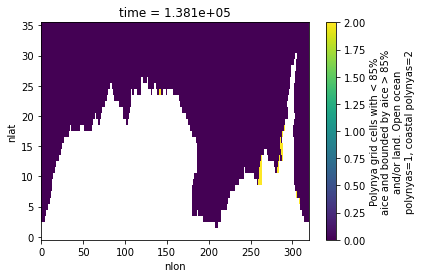

In [13]:
polynyas.isel(time=0).plot()

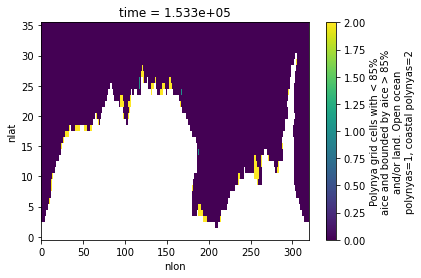

In [14]:
polynyas.isel(time=500).plot()

In [15]:
# Set all polynyas to be in mask since there are so few open water polynyas
# In the file, 0 = not polynya, 1 = open water polynya, 2 = coastal polynya
# We want to look at all polynyas for now, so set coastal to one also
polynyas = polynyas.where(polynyas != 2,1)

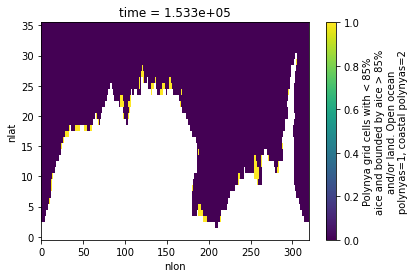

In [16]:
# check
polynyas.isel(time=500).plot()

### Fix time array to be useable

In [17]:
# looks like there are 504 times, which is 42 yrs * 12 months
# starts 197901-202012
polynyas.time

<xarray.DataArray 'time' (time: 504)>
array([138076. , 138105.5, 138135. , ..., 153325. , 153355.5, 153386. ],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.381e+05 1.381e+05 ... 1.534e+05 1.534e+05
Attributes:
    cell_methods:  time: mean

In [18]:
# make array of the dates
dates = pd.date_range(start="1979-01-15", end="2021-01-15", freq="M")

In [19]:
# check length
print(len(dates))
dates

504


DatetimeIndex(['1979-01-31', '1979-02-28', '1979-03-31', '1979-04-30',
               '1979-05-31', '1979-06-30', '1979-07-31', '1979-08-31',
               '1979-09-30', '1979-10-31',
               ...
               '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               '2020-11-30', '2020-12-31'],
              dtype='datetime64[ns]', length=504, freq='M')

In [20]:
# reassign the polynya time array
polynyas['time'] = dates

In [21]:
polynyas.time.dt.month

<xarray.DataArray 'month' (time: 504)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2020-12-31

## Calculate typical polynya areas
- Areas that are counted as polynya > 10% of the time (in that season)
- Look at whole year and winter (JAS) and spring (OND) seasons

### Calculate for whole record (1979-2020)

In [22]:
polynyas_winter = polynyas.where((polynyas.time.dt.month >= 7) & (polynyas.time.dt.month <= 9), drop=True)
#polynyas_winter.time

In [23]:
polynyas_spring = polynyas.where((polynyas.time.dt.month >= 10) & (polynyas.time.dt.month <= 12), drop=True)
#polynyas_spring.time

In [24]:
# calculate percent over all years
total_time = len(polynyas.time)
winter_time = len(polynyas_winter.time)
spring_time = len(polynyas_spring.time)

pct_all = polynyas.sum(dim='time')/total_time
pct_winter = polynyas_winter.sum(dim='time')/winter_time
pct_spring = polynyas_spring.sum(dim='time')/spring_time

In [25]:
# make arrays of "typical" polynyas

# make array to fill
polynya_typical_all = pct_all.where(pct_all == 1, other = 1)
polynya_typical_winter = pct_winter.where(pct_winter == 1, other = 1)
polynya_typical_spring = pct_spring.where(pct_spring == 1, other = 1)

# keep values where polynyas > 10% (0.1) of the time
polynya_typical_all = polynya_typical_all.where(pct_all >= 0.1)
polynya_typical_winter = polynya_typical_winter.where(pct_winter >= 0.1)
polynya_typical_spring = polynya_typical_spring.where(pct_spring >= 0.1)

In [38]:
# assign some coordinates for later
polynya_typical_all['TLAT'] = ds_grid.TLAT
polynya_typical_all['TLONG'] = ds_grid.TLONG
polynya_typical_all['TAREA'] = ds_grid.TAREA

### Calculate for "present day" record (2000-2020)

In [26]:
polynyas_present = polynyas.where((polynyas.time.dt.year >=2000),drop=True)

In [27]:
polynyas_present_winter = polynyas.where((polynyas_present.time.dt.month >= 7) & (polynyas_present.time.dt.month <= 9), drop=True)
#polynyas_present_winter.time

In [28]:
polynyas_present_spring = polynyas.where((polynyas_present.time.dt.month >= 10) & (polynyas_present.time.dt.month <= 12), drop=True)
#polynyas_present_spring.time

In [29]:
# calculate percent over all years
total_time_present = len(polynyas_present.time)
winter_time_present = len(polynyas_present_winter.time)
spring_time_present = len(polynyas_present_spring.time)

pct_all_present = polynyas_present.sum(dim='time')/total_time_present
pct_winter_present = polynyas_present_winter.sum(dim='time')/winter_time_present
pct_spring_present = polynyas_present_spring.sum(dim='time')/spring_time_present

In [30]:
# make arrays of "typical" polynyas

# make array to fill
polynya_typical_all_present = pct_all_present.where(pct_all_present == 1, other = 1)
polynya_typical_winter_present = pct_winter_present.where(pct_winter_present == 1, other = 1)
polynya_typical_spring_present = pct_spring_present.where(pct_spring_present == 1, other = 1)

# keep values where polynyas > 10% (0.1) of the time
polynya_typical_all_present = polynya_typical_all_present.where(pct_all_present >= 0.1)
polynya_typical_winter_present = polynya_typical_winter_present.where(pct_winter_present >= 0.1)
polynya_typical_spring_present = polynya_typical_spring_present.where(pct_spring_present >= 0.1)

## Put together into one dataset

- Netcdf with variable dimension: (nlat x nlon)

In [39]:
ds_out = xr.Dataset()

ds_out['polynya_typical_all'] = polynya_typical_all
ds_out['polynya_typical_winter'] = polynya_typical_winter
ds_out['polynya_typical_spring'] = polynya_typical_spring
ds_out['polynya_typical_all_present'] = polynya_typical_all_present
ds_out['polynya_typical_winter_present'] = polynya_typical_winter_present
ds_out['polynya_typical_spring_present'] = polynya_typical_spring_present

ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'Typical polynyas from SSMI CDR data for whole year, winter (JAS), and spring (OND). For whole record (1979-2020) and "present day" period (2000-2020).'

ds_out

<xarray.Dataset>
Dimensions:                         (nlat: 36, nlon: 320)
Coordinates:
  * nlat                            (nlat) int64 0 1 2 3 4 5 ... 31 32 33 34 35
  * nlon                            (nlon) int64 0 1 2 3 4 ... 316 317 318 319
    ULONG                           (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ULAT                            (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLONG                           (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT                            (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TAREA                           (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Data variables:
    polynya_typical_all             (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    polynya_typical_winter          (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    polynya_typical_spring          (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    polynya_typical_all_present     (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    polynya_typical_winter_present  (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    polynya_typical_spring_present  (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2024-10-16
    contents:        Typical polynyas from SSMI CDR data for whole year, wint...

In [40]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")

Dimensions:
	nlat: (36,)
	nlon: (320,)
Coordinates:
	nlat:
		[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
	nlon:
		[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201

## Export and Save

In [41]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.00 GB.


In [42]:
path_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'
file_out = 'CESM_grid_SSMI_typical_polynya.nc'
fout = path_out + file_out

In [43]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)